In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;import matplotlib as mpl; 


In [13]:
fs=12; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
font = {'family' : 'Times New Roman',
        'size'   : fs}
mpl.rc('font', **font)

In [17]:
BasicPath = 'D:/OneDrive - Imperial College London/SimDataSave/P3R13/Paper/'; 
Target  = 'Plot_para/' 
if not os.path.exists(BasicPath + Target):
   os.mkdir(BasicPath + Target)

In [6]:
# Landesfeind electrolyte properties 
def electrolyte_conductivity_base_Landesfeind2019(c_e,c_EC, T, coeffs):
    c = (
        (c_e >= 0 ) * c_e / 1000 
        +  (c_e < 0 ) * 0  
        )# mol.m-3 -> mol.l
    p1, p2, p3, p4, p5, p6 = coeffs
    A = p1 * (1 + (T - p2))
    B = 1 + p3 * np.sqrt(c) + p4 * (1 + p5 * np.exp(1000 / T)) * c
    C = 1 + c**4 * (p6 * np.exp(1000 / T))
    sigma_e = A * c * B / C  # mS.cm-1
    return sigma_e / 10

def electrolyte_diffusivity_base_Landesfeind2019(c_e,c_EC, T, coeffs):
    c = (
        (c_e >= 0 ) * c_e / 1000 
        +  (c_e < 0 ) * 0  
        )# mol.m-3 -> mol.l
    p1, p2, p3, p4 = coeffs
    A = p1 * np.exp(p2 * c)
    B = np.exp(p3 / T)
    C = np.exp(p4 * c / T)
    D_e = A * B * C * 1e-10  # m2/s
    return D_e
def electrolyte_transference_number_base_Landesfeind2019(c_e,c_EC, T, coeffs):
    c = c_e / 1000  # mol.m-3 -> mol.l
    p1, p2, p3, p4, p5, p6, p7, p8, p9 = coeffs
    tplus = (
        p1
        + p2 * c
        + p3 * T
        + p4 * c**2
        + p5 * c * T
        + p6 * T**2
        + p7 * c**3
        + p8 * c**2 * T
        + p9 * c * T**2
    )
    return tplus

def electrolyte_diffusivity_EC_DMC_1_1_Landesfeind2019_Con(c_e, c_EC,T):
    coeffs = np.array([1.47e3, 1.33, -1.69e3, -5.63e2])
    c_e_constant = 4000
    diff_f = (
        (c_e <= c_e_constant) * electrolyte_diffusivity_base_Landesfeind2019(c_e,c_EC, T, coeffs)
        +
        (c_e > c_e_constant) * electrolyte_diffusivity_base_Landesfeind2019(c_e_constant,c_EC, T, coeffs)
    )
    return diff_f

def electrolyte_diffusivity_EC_DMC_1_1_Landesfeind2019(c_e, c_EC,T):
    coeffs = np.array([1.47e3, 1.33, -1.69e3, -5.63e2])
    return electrolyte_diffusivity_base_Landesfeind2019(c_e,c_EC, T, coeffs)

def electrolyte_conductivity_EC_DMC_1_1_Landesfeind2019(c_e,c_EC, T):
    coeffs = np.array([7.98e-1, 2.28e2, -1.22, 5.09e-1, -4e-3, 3.79e-3])
    return electrolyte_conductivity_base_Landesfeind2019(c_e,c_EC, T, coeffs)

def electrolyte_conductivity_EC_DMC_1_1_Landesfeind2019_Con(c_e,c_EC, T):
    coeffs = np.array([7.98e-1, 2.28e2, -1.22, 5.09e-1, -4e-3, 3.79e-3])
    c_e_constant = 4000
    sigma = (
        (c_e <= c_e_constant) * electrolyte_conductivity_base_Landesfeind2019(c_e,c_EC, T, coeffs)
        +
        (c_e > c_e_constant) * electrolyte_conductivity_base_Landesfeind2019(c_e_constant,c_EC, T, coeffs)
    )
    return sigma
def electrolyte_transference_number_EC_DMC_1_1_Landesfeind2019(c_e,c_EC, T):
    coeffs = np.array(
        [
            -7.91,
            2.45e-1,
            5.28e-2,
            6.98e-1,
            -1.08e-2,
            -8.21e-5,
            7.43e-4,
            -2.22e-3,
            3.07e-5,
        ]
    )
    return electrolyte_transference_number_base_Landesfeind2019(c_e,c_EC, T, coeffs)
def electrolyte_transference_number_EC_DMC_1_1_Landesfeind2019_Con(c_e,c_EC, T):
    coeffs = np.array(
        [
            -7.91,
            2.45e-1,
            5.28e-2,
            6.98e-1,
            -1.08e-2,
            -8.21e-5,
            7.43e-4,
            -2.22e-3,
            3.07e-5,
        ]
    )
    c_e_constant = 4000
    t0plus = (
        (c_e <= c_e_constant) * electrolyte_transference_number_base_Landesfeind2019(c_e,c_EC, T, coeffs)
        + 
        (c_e > c_e_constant) * electrolyte_transference_number_base_Landesfeind2019(c_e_constant,c_EC, T, coeffs)
    )
    return t0plus

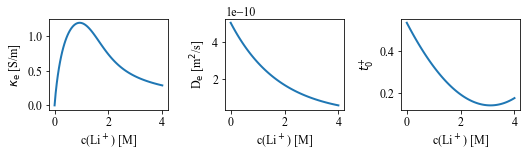

In [18]:
# plot Landesfeind2019 EC_DMC_1_1
N=100
c_e = np.linspace(0, 4000, N); T_0 = 298.15; lw=2
aa=np.array(electrolyte_diffusivity_EC_DMC_1_1_Landesfeind2019_Con(c_e,4000,T_0))
fig, axs = plt.subplots(1,3, figsize=(19/2.54,6/2.54),tight_layout=True) # 

axs[0].plot(
    c_e/1e3, 
    electrolyte_conductivity_EC_DMC_1_1_Landesfeind2019_Con(c_e,4000,T_0), 
    lw=lw, ) 
axs[1].plot(
    c_e/1e3, 
    electrolyte_diffusivity_EC_DMC_1_1_Landesfeind2019_Con(c_e,4000,T_0), 
    lw=lw, ) 
axs[2].plot(
    c_e/1e3, 
    electrolyte_transference_number_EC_DMC_1_1_Landesfeind2019_Con(c_e,4000,T_0), 
    lw=lw, ) 
for i in range(3):
    axs[i].set_xlabel(r"c(Li$^+$) [M]")

axs[0].set_ylabel("$\kappa_\mathrm{e}$ [S/m]")
axs[1].set_ylabel("D$_\mathrm{e}$ [m$^\mathrm{2}$/s]") # 
axs[2].set_ylabel("$\mathit{t}_\mathrm{0}^\mathrm{+}$")
plt.savefig(BasicPath +  Target+ 
    f"Landesfeind2019 EC_DMC_1_1.png", dpi=1000)
plt.savefig(BasicPath +  Target+ 
    f"Landesfeind2019 EC_DMC_1_1.svg")  


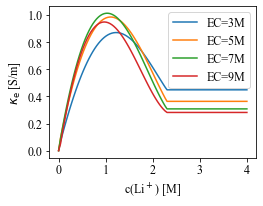

In [27]:
# electrolyte_conductivity_Andrew2022_poly4
def electrolyte_conductivity_Andrew2022_poly4(x1,y1, T):# x:Li+,y:ec
    p00 =      0.9608 # (0.9188, 1.003)
    p10 =      0.1502 # (0.09883, 0.2015)
    p01 =       0.173 # (0.1481, 0.1979)
    p20 =     -0.3934 # (-0.4666, -0.3202)
    p11 =     -0.1179 # (-0.1627, -0.07308)
    p02 =     -0.1472 # (-0.1767, -0.1176)
    p30 =     0.04244 # (0.01066, 0.07422)
    p21 =     -0.1197 # (-0.1423, -0.09704)
    p12 =   -0.003226 # (-0.02331, 0.01686)
    p40 =     0.01664 # (-0.01452, 0.0478)
    p31 =     0.05145 # (0.02312, 0.07978)
    p22 =     0.05983 # (0.0346, 0.08506)
    x1 = (x1<2300)*x1 + (x1>=2300)*2300
    x= (x1-971.4 )/733.1
    y= (y1-4737) / 3439
    kai  = (
        (x1 > 0 )  * (
        p00 + p10*x + p01*y + p20*x*x + p11*x*y + p02*y*y + p30*x*x*x + p21*x*x*y 
        + p12*x*y*y + p40*x*x*x*x + p31*x*x*x*y + p22*x*x*y*y
        )
        + (x1 <= 0 ) * 0 )
    kai_final = (kai>0) * kai + (kai<0) * 0
    return kai_final

fig, axs = plt.subplots(figsize=(9/2.54,7/2.54),layout='constrained')

c_e = np.linspace(0, 4000, N); T_0 = 25
#kai = electrolyte_conductivity_Andrew2022_poly4(c_e,3000,293.75)
#plt.plot(c_e,electrolyte_conductivity_Andrew2022_poly4(c_e,0,293.75),label="EC=0M")
#plt.plot(c_e,electrolyte_conductivity_Andrew2022_poly4(c_e,2000,T_0),label="EC=2M")
plt.plot(c_e/1e3,electrolyte_conductivity_Andrew2022_poly4(c_e,3000,T_0),label="EC=3M")
plt.plot(c_e/1e3,electrolyte_conductivity_Andrew2022_poly4(c_e,5000,T_0),label="EC=5M")
plt.plot(c_e/1e3,electrolyte_conductivity_Andrew2022_poly4(c_e,7000,T_0),label="EC=7M")
plt.plot(c_e/1e3,electrolyte_conductivity_Andrew2022_poly4(c_e,9000,T_0),label="EC=9M")
#plt.plot(c_e,electrolyte_conductivity_Andrew2022_poly4(c_e,10000,T_0),label="EC=10M")
plt.legend()
axs.set_xlabel(r"c(Li$^+$) [M]")
axs.set_ylabel("$\kappa_\mathrm{e}$ [S/m]")
plt.savefig(BasicPath +  Target+ 
    f"electrolyte_conductivity_Andrew2022_poly4.png", dpi=1000)
plt.savefig(BasicPath +  Target+ 
    f"electrolyte_conductivity_Andrew2022_poly4.svg")  

In [65]:
# Nyman
# Define electrolyte diffusivity and conductivity
def electrolyte_diffusivity_Nyman2008(c_e, T):
    D_c_e = 8.794e-11 * (c_e / 1000) ** 2 - 3.972e-10 * (c_e / 1000) + 4.862e-10
    return D_c_e    
def electrolyte_conductivity_Nyman2008(c_e, T):
    sigma_e = (0.1297 * (c_e / 1000) ** 3 - 2.51 * (c_e / 1000) ** 1.5 + 3.329 * (c_e / 1000))
    return sigma_e

def electrolyte_diffusivity_Nyman2008_con(c_e, T):
    c_e = (c_e <= 2200)*c_e + (c_e > 2200)*2200 
    D_c_e = 8.794e-11 * (c_e / 1000) ** 2 - 3.972e-10 * (c_e / 1000) + 4.862e-10
    return D_c_e    
def electrolyte_conductivity_Nyman2008_con(c_e, T):
    c_e = (c_e <= 2200)*c_e + (c_e > 2200)*2200
    sigma_e = (0.1297 * (c_e / 1000) ** 3 - 2.51 * (c_e / 1000) ** 1.5 + 3.329 * (c_e / 1000))
    return sigma_e
def electrolyte_conductivity_Valoen2005(c_e, T):   # valid concentration: 0~4000 mol/m3
    sigma_e = 0.1 * (-10.5 + 0.668*(1e-3*c_e) + 0.494*(1e-6*c_e**2) + 0.074*T - 0.0178*(1e-3*c_e)*T - 8.86e-4*(1e-6*c_e**2)*T - 6.96e-5*T**2 + 2.8E-5*(1E-3*c_e)*T**2 ) **2 * (1e-3*c_e)
    return sigma_e
def electrolyte_diffusivity_Valoen2005(c_e, T):
    D_c_e = 1e-4 * 10**(-4.43 - 54/(T - 229 - 0.005*c_e) - 2.2e-4 * c_e   )
    return D_c_e

def electrolyte_conductivity_Ecker2015(c_e, T):
    # mol/m^3 to mol/l
    cm = 1e-3 * c_e
    # value at T = 296K
    sigma_e_296 = 0.2667 * cm ** 3 - 1.2983 * cm ** 2 + 1.7919 * cm + 0.1726
    # Add temperature dependence
    E_k_e = 1.71e4
    C = 296 * exp(E_k_e / (constants.R * 296))
    sigma_e = C * sigma_e_296 * exp(-E_k_e / (constants.R * T)) / T
    return sigma_e.value
def electrolyte_diffusivity_Ecker2015(c_e, T):
    # mol/m^3 to mol/l
    cm = 1e-3 * c_e
    # value at T = 296K
    sigma_e_296 = 0.2667 * cm ** 3 - 1.2983 * cm ** 2 + 1.7919 * cm + 0.1726
    # add temperature dependence
    E_k_e = 1.71e4
    C = 296 * exp(E_k_e / (constants.R * 296))
    sigma_e = C * sigma_e_296 * exp(-E_k_e / (constants.R * T)) / T
    D_c_e = (constants.k_b / (constants.F * constants.q_e)) * sigma_e * T / c_e
    return D_c_e.value

def electrolyte_conductivity_Ding2001(c_e, c_EC,  T):
    # c_e is lithium ion concentration in electrolyte in mol/m3, need to change to mol/kg
    # also be careful that T here is deg, while others are K
    rho_electrolyte = 1300 # in kg/m3
    c_e_kg = c_e / rho_electrolyte     # in mol/kg 
    M_LiPF6 = 151.905/1000  # kg/mol
    M_EC = 88.062/1000  # kg/mol
    M_EMC = 104.104/1000 # kg/mol
    x_EC = 1 / (1+ ( rho_electrolyte - c_e*M_LiPF6 - c_EC*M_EC  )/M_EMC/c_EC   )
    kai = -3.37115 + 12.5608*c_e_kg - 7.89593*c_e_kg**2 + 3.51922*c_e_kg**3-1.15471*c_e_kg**4 +18.1863*x_EC - 6.22756*c_e_kg*x_EC - 13.6916*c_e_kg**2*x_EC +8.43904*c_e_kg**3*x_EC - 7.83732*x_EC**2 + 19.607*c_e_kg*x_EC**2  - 18.4529*c_e_kg**2*x_EC**2 -30.6369*x_EC**3 + 29.2*c_e_kg*x_EC**3 - 0.0429918*T + 0.180877*c_e_kg*T -0.0836202*c_e_kg**2*T + 0.0230098*c_e_kg**3*T + 0.195946*T*x_EC +0.0676686*c_e_kg*x_EC*T - 0.14134*c_e_kg**2*x_EC*T + 0.147429*x_EC**2*T  +0.173059*c_e_kg*x_EC**2*T - 0.51634*x_EC**3*T - 0.000223097*T**2 +0.000111233*c_e_kg*T**2 + 0.0000495286*c_e_kg**2*T**2  +0.000952777*x_EC*T**2 + 0.00117334 *c_e_kg*x_EC*T**2-0.000619157*x_EC**2*T**2 - 3.46897E-7*T**3 - 2.75041E-6*c_e_kg*T**3 -5.57653E-6*x_EC*T**3 
    return kai 

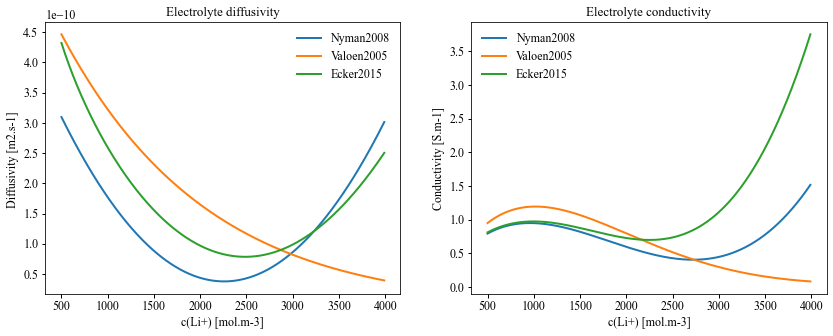

In [66]:
# Plot other elely properties
ce = np.arange(500,4000.0,10.0); T = np.full(ce.shape,298.15) ; c_EC = np.full(ce.shape,4540.0)  # standard T is 273.15; 25=298.15;     paper is 0.4 to 3.4 M experimentally; and 10 to 4000 curve fit
# ce = 1200.3; T = 298.15; # T = np.full(ce.shape,298.15) 
# T = np.full(np.size(ce),298.15) 
sigma_e_Nyman2008 =[]; D_c_e_Nyman2008 = []; 
sigma_e_Nyman2008_con =[]; D_c_e_Nyman2008_con = [];
sigma_e_Valoen2005 =[]; D_c_e_Valoen2005 = []; 
sigma_e_Ecker2015 =[]; D_c_e_Ecker2015 = []; 
sigma_e_Ding2001 =[];  
# sigma_e = np.full(ce.shape,0.0); D_c_e  = np.full(ce.shape,0.0);  #  
for ce_i in ce:
    # print(type(i))
    # print(ce[i])       
    # print(type(electrolyte_conductivity_Valoen2005(ce[i], T[i])))
    # print(dir(electrolyte_conductivity_Valoen2005(ce[i], T[i])))
    # print(electrolyte_conductivity_Valoen2005(ce[i], T[i]).data)
    # print(sigma_e[i])      
    sigma_e_Nyman2008.append(   electrolyte_conductivity_Nyman2008(ce_i, 298.15)  ) 
    D_c_e_Nyman2008.append  (   electrolyte_diffusivity_Nyman2008 (ce_i, 298.15)    )
    sigma_e_Nyman2008_con.append(   electrolyte_conductivity_Nyman2008_con(ce_i, 298.15)  ) 
    D_c_e_Nyman2008_con.append  (   electrolyte_diffusivity_Nyman2008_con (ce_i, 298.15)    )
    sigma_e_Valoen2005.append(   electrolyte_conductivity_Valoen2005(ce_i, 298.15)  ) 
    D_c_e_Valoen2005.append  (   electrolyte_diffusivity_Valoen2005 (ce_i, 298.15)    )
    sigma_e_Ecker2015.append(   electrolyte_conductivity_Ecker2015(ce_i, 298.15)  ) 
    D_c_e_Ecker2015.append  (   electrolyte_diffusivity_Ecker2015(ce_i, 298.15)    )
    sigma_e_Ding2001.append(   electrolyte_conductivity_Ding2001(ce_i,4340, 298.15)  ) 


lw = 2;
fig, axs = plt.subplots(1,2, figsize=(14,5))
axs[0].plot(list(ce), D_c_e_Nyman2008, lw=2, label='Nyman2008') 
axs[0].plot(list(ce), D_c_e_Valoen2005, lw=2, label='Valoen2005') 
axs[0].plot(list(ce), D_c_e_Ecker2015 , lw=2, label='Ecker2015') 
axs[0].set_xlabel("c(Li+) [mol.m-3]", fontdict={'family':'Times New Roman','size':fs})
axs[0].set_ylabel("Diffusivity [m2.s-1] ", fontdict={'family':'Times New Roman','size':fs})
labels = axs[0].get_xticklabels() + axs[0].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
axs[0].tick_params(labelcolor='k', labelsize=fs, width=1) ; del labels;
axs[0].legend(prop={'family':'Times New Roman','size':fs},loc='best',frameon=False)
axs[0].set_title("Electrolyte diffusivity",   fontdict={'family':'Times New Roman','size':fs+1})

axs[1].plot(list(ce), sigma_e_Nyman2008, lw=2, label='Nyman2008') 
axs[1].plot(list(ce), sigma_e_Valoen2005, lw=2, label='Valoen2005') 
axs[1].plot(list(ce), sigma_e_Ecker2015 , lw=2, label='Ecker2015')  
# axs[1].plot(list(ce), sigma_e_Ding2001 , lw=2, label='Ding2001')
axs[1].set_xlabel("c(Li+) [mol.m-3]", fontdict={'family':'Times New Roman','size':fs})
axs[1].set_ylabel("Conductivity [S.m-1]", fontdict={'family':'Times New Roman','size':fs})
labels = axs[1].get_xticklabels() + axs[1].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
axs[1].tick_params(labelcolor='k', labelsize=fs, width=1) ; del labels;
axs[1].legend(prop={'family':'Times New Roman','size':fs},loc='best',frameon=False)
axs[1].set_title("Electrolyte conductivity",   fontdict={'family':'Times New Roman','size':fs+1})


plt.savefig(BasicPath + Target+"Valoen Ecker Nyman Electrolyte conductivity and diffusivity.png", dpi=600)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


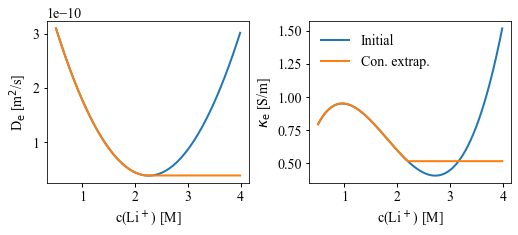

In [67]:
# plot for paper 2 (double transport):
fs = 14
font = {'family' : 'Times New Roman','size'   : fs}
mpl.rc('font', **font)
lw = 2;
fig, axs = plt.subplots(1,2, figsize=(18/2.54,8/2.54),layout='constrained')
axs[0].plot(list(ce/1E3), D_c_e_Nyman2008, lw=lw, ) 
axs[0].plot(list(ce/1E3), D_c_e_Nyman2008_con, lw=lw, ) 

axs[0].set_xlabel(r"c(Li$^+$) [M]")
axs[0].set_ylabel("D$_\mathrm{e}$ [m$^\mathrm{2}$/s]")
labels = axs[0].get_xticklabels() + axs[0].get_yticklabels(); 
[label.set_fontname('Times New Roman') for label in labels]
axs[0].tick_params(labelcolor='k', labelsize=fs, width=1) ; del labels;
axs[0].legend(prop={'family':'Times New Roman','size':fs},loc='best',frameon=False)
#axs[0].set_title("Electrolyte diffusivity",   fontdict={'family':'Times New Roman','size':fs+1})

axs[1].plot(list(ce/1E3), sigma_e_Nyman2008, lw=2,label='Initial' ) 
axs[1].plot(list(ce/1E3), sigma_e_Nyman2008_con, lw=2, label='Con. extrap.') 

axs[1].set_xlabel(r"c(Li$^+$) [M]")
axs[1].set_ylabel("$\kappa_\mathrm{e}$ [S/m]")
axs[1].tick_params(labelcolor='k', labelsize=fs, width=1) ;
axs[1].legend(prop={'family':'Times New Roman','size':fs},loc='best',frameon=False)
#axs[1].set_title("Electrolyte conductivity",   fontdict={'family':'Times New Roman','size':fs+1})
plt.savefig(BasicPath +  Target+ 
    f"Nyman initial and constant extrapolation.png", dpi=1000)
plt.savefig(BasicPath +  Target+ 
    f"Nyman initial and constant extrapolation.svg")  


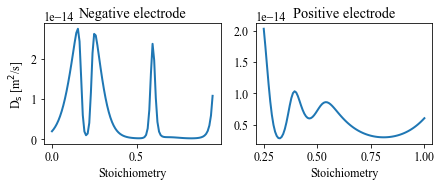

In [50]:
# plot electrode diffusivity
fs=12; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
font = {'family' : 'Times New Roman',
        'size'   : fs}
mpl.rc('font', **font)

def nmc_LGM50_diffusivity_ORegan2022(sto, T):
    a1 = -0.9231
    a2 = -0.4066
    a3 = -0.993
    b1 = 0.3216
    b2 = 0.4532
    b3 = 0.8098
    c0 = -13.96
    c1 = 0.002534
    c2 = 0.003926
    c3 = 0.09924
    d = 1449

    D_ref = (
        10
        ** (
            c0
            + a1 * np.exp(-((sto - b1) ** 2) / c1)
            + a2 * np.exp(-((sto - b2) ** 2) / c2)
            + a3 * np.exp(-((sto - b3) ** 2) / c3)
        )
        * 2.7  # correcting factor (see O'Regan et al 2021)
    )

    E_D_s = d * pybamm.constants.R.value
    arrhenius = np.exp(E_D_s / pybamm.constants.R.value * (1 / 298.15 - 1 / T))

    return D_ref * arrhenius
def graphite_LGM50_diffusivity_ORegan2022(sto, T):
    a0 = 11.17
    a1 = -1.553
    a2 = -6.136
    a3 = -9.725
    a4 = 1.85
    b1 = 0.2031
    b2 = 0.5375
    b3 = 0.9144
    b4 = 0.5953
    c0 = -15.11
    c1 = 0.0006091
    c2 = 0.06438
    c3 = 0.0578
    c4 = 0.001356
    d = 2092

    D_ref = (
        10
        ** (
            a0 * sto
            + c0
            + a1 * np.exp(-((sto - b1) ** 2) / c1)
            + a2 * np.exp(-((sto - b2) ** 2) / c2)
            + a3 * np.exp(-((sto - b3) ** 2) / c3)
            + a4 * np.exp(-((sto - b4) ** 2) / c4)
        )
        * 3.0321  # correcting factor (see O'Regan et al 2021)
    )

    E_D_s = d * pybamm.constants.R.value
    arrhenius = np.exp(E_D_s / pybamm.constants.R.value * (1 / 298.15 - 1 / T))

    return D_ref * arrhenius

N=100
sto_neg = np.linspace(0, 0.95, N); T_0 = 298.15; lw=2
sto_pos = np.linspace(0.25, 1, N);
fig, axs = plt.subplots(1,2, figsize=(16/2.54,7/2.54),tight_layout=True) # 

axs[0].plot(
    sto_neg, 
    graphite_LGM50_diffusivity_ORegan2022(sto_neg,T_0), 
    lw=lw, ) 
axs[1].plot(
    sto_pos, 
    nmc_LGM50_diffusivity_ORegan2022(sto_pos,T_0), 
    lw=lw, ) 
for i in range(2):
    axs[i].set_xlabel(r"Stoichiometry")
axs[0].set_ylabel("D$_\mathrm{s}$ [m$^\mathrm{2}$/s]") # 
axs[0].set_title("Negative electrode") # 
axs[1].set_title("Positive electrode") # 
plt.savefig(BasicPath +  Target+ 
    f"Electrode diffusivity.png", dpi=1000)
plt.savefig(BasicPath +  Target+ 
    f"Electrode diffusivity.svg")  # """

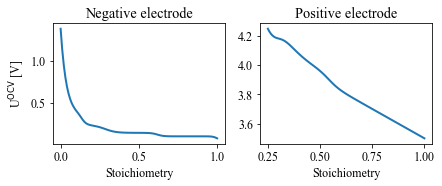

In [56]:
# plot electrode OCP:
def graphite_LGM50_delithiation_ocp_OKane2023(sto):
    u_eq = (
        1.051 * np.exp(-26.76 * sto)
        + 0.1916
        - 0.05598 * np.tanh(35.62 * (sto - 0.1356))
        - 0.04483 * np.tanh(14.64 * (sto - 0.2861))
        - 0.02097 * np.tanh(26.28 * (sto - 0.6183))
        - 0.02398 * np.tanh(38.1 * (sto - 1))
    )
    return u_eq
def nmc_LGM50_lithiation_ocp_OKane2023(sto):
    U = (
        -0.7983 * sto
        + 4.513
        - 0.03269 * np.tanh(19.83 * (sto - 0.5424))
        - 18.23 * np.tanh(14.33 * (sto - 0.2771))
        + 18.05 * np.tanh(14.46 * (sto - 0.2776))
    )

    return U
#

N=100
sto_neg = np.linspace(0, 1, N); T_0 = 298.15; lw=2
sto_pos = np.linspace(0.25, 1, N);
fig, axs = plt.subplots(1,2, figsize=(16/2.54,7/2.54),tight_layout=True) # 

axs[0].plot(
    sto_neg, 
    graphite_LGM50_delithiation_ocp_OKane2023(sto_neg), 
    lw=lw, ) 
axs[1].plot(
    sto_pos, 
    nmc_LGM50_lithiation_ocp_OKane2023(sto_pos), 
    lw=lw, ) 
for i in range(2):
    axs[i].set_xlabel(r"Stoichiometry")
axs[0].set_ylabel("U$^\mathrm{OCV}$ [V]") # 
axs[0].set_title("Negative electrode") # 
axs[1].set_title("Positive electrode") # 
plt.savefig(BasicPath +  Target+ 
    f"Electrode OCP.png", dpi=1000)
plt.savefig(BasicPath +  Target+ 
    f"Electrode OCP.svg")  

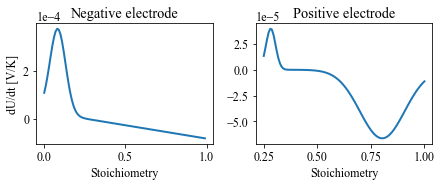

In [63]:
# dU/dt
def nmc_LGM50_entropic_change_ORegan2022(sto, c_s_max):
    a1 = 0.04006
    a2 = -0.06656
    b1 = 0.2828
    b2 = 0.8032
    c1 = 0.0009855
    c2 = 0.02179

    dUdT = (
        a1 * np.exp(-((sto - b1) ** 2) / c1)
        + a2 * np.exp(-((sto - b2) ** 2) / c2)
    ) / 1000
    # fit in mV / K
    return dUdT
def graphite_LGM50_entropic_change_ORegan2022(sto, c_s_max):
    a0 = -0.1112
    a1 = -0.09002 * 0  # fixed fit (see discussion O'Regan et al 2021)
    a2 = 0.3561
    b1 = 0.4955
    b2 = 0.08309
    c0 = 0.02914
    c1 = 0.1122
    c2 = 0.004616
    d1 = 63.9

    dUdT = (
        a0 * sto
        + c0
        + a2 * np.exp(-((sto - b2) ** 2) / c2)
        + a1
        * (np.tanh(d1 * (sto - (b1 - c1))) - np.tanh(d1 * (sto - (b1 + c1))))
    ) / 1000  # fit in mV / K

    return dUdT
#
N=100
sto_neg = np.linspace(0, 0.99, N); T_0 = 298.15; lw=2
sto_pos = np.linspace(0.25, 1, N);
fig, axs = plt.subplots(1,2, figsize=(16/2.54,7/2.54),tight_layout=True) # 

axs[0].plot(
    sto_neg, 
    graphite_LGM50_entropic_change_ORegan2022(sto_neg, 1), 
    lw=lw, ) 
axs[1].plot(
    sto_pos, 
    nmc_LGM50_entropic_change_ORegan2022(sto_pos, 1), 
    lw=lw, ) 
for i in range(2):
    axs[i].set_xlabel(r"Stoichiometry")
    axs[i].ticklabel_format( 
        axis='y', style='sci',
        scilimits=[-1e-3,1e-3], useOffset=None, 
        useLocale=None, useMathText=None)
axs[0].set_ylabel("dU/dt [V/K]") # 
axs[0].set_title("Negative electrode") # 
axs[1].set_title("Positive electrode") # 
plt.savefig(BasicPath +  Target+ 
    f"Electrode dU_dt.png", dpi=1000)
plt.savefig(BasicPath +  Target+ 
    f"Electrode dU_dt.svg")  

In [34]:
#graphite_LGM50_diffusivity_ORegan2022(0.1,T_0)
pybamm.constants.R.value

8.314462618